# 從pytorch的dataloader進行模型訓練

步驟0. 是否使用CUDA <br>
步驟1. data loader處理 <br> 
步驟2. 模型宣告 <br> 
步驟3. loss function宣告 <br>
步驟4. optimator宣告 <br>
步驟5. 模型開始訓練 <br>

----------------------
**<font color = black size=3> 步驟0.是否使用CUDA</font>**<br>
<br>宣告一個device決定CPU或是GPU運算</br>

In [1]:
import torch
use_cuda=1
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


上面是我們自己說要下到cuda裡面，但實際上沒有cuda就慘了

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)
type(device)

cuda


torch.device

----------------------
**<font color = blue size=4> 步驟1. data loader處理</font>**<br>
<br>這個前面內容提過了，我就帶過<br>

In [3]:
from torchvision import datasets, transforms
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=4)

----------------------
**<font color = blue size=4> 步驟2. 模型宣告</font>**<br>

<br>這邊在宣告你要用什麼神經網路，自己兜得或是開源模型都可以<br>
<br>**這邊我宣告兩種簡單的模型**<br>
1. MLP，接上幾層funnly connection的神經網路
2. ConvNet，用conv+BN+ReLU，串幾層CNN的神經網路

**1. MLP，接上幾層funnly connection的神經網路** <br>
<br>這邊我們用一個三層的MLP </br>
<br>因為全連接層圖片須拉成1D array，所以28x28的手寫圖片需要轉換成一個28x28=754的一維陣列</br>
<br>所以神經網路的結構為</br>
<br> Input layer (node數為754) → Hidden layer (node數設定為512) → Output layer (node數為10)</br>


In [4]:
## 1. MLP
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512,10)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = self.fc2(x)
        return x
# initialize the MLP
model_mlp = MLP()
print(model_mlp)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


**2. ConvNet，用conv+BN+ReLU，串幾層CNN的神經網路** <br>

<br>這邊我們用一個3層的CNN </br>
<br>每個conv. layer都會用</br>
<br>所以CNN神經網路的結構為conv+BN+ReLU2的結構</br>
<br> Input layer (channel數為1) → conv layer 1 (channel數設定為32)→ conv layer2 (channel數設定為32) → GAP → Output layer (channel數為10)</br>
> GAP: global average pooling

In [5]:
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            ConvM(1, 32, 3, 1),
            ConvM(32, 64, 3, 1),
            ConvM(64, 128, 3, 1),
            ConvM(128, 64, 3, 1),
            ConvM(64, 32, 3, 1),
        )        
        self.fc = nn.Linear(32, 10)
    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

# initialize the ConvNet
model_cnn = ConvNet()
print(model_cnn)

ConvNet(
  (conv): Sequential(
    (0): ConvM(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvM(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): ConvM(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): ConvM(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): ConvM(
      (0): Conv2d(64, 3

----------------------
**<font color = blue size=4> 步驟3.loss function宣告</font>**<br>
<br>宣告loss函數，模型預測的結果和ground truth整合計算差異用來更新模型</br>
<br>這邊提的是和ground truth整合計算差異所以泛屬於supervised learning</br>
<br>reference:https://pytorch.org/docs/stable/nn.html#loss-functions

<br>**這邊我們用到的是cross entropy作為loss function**
<br>torch.nn.CrossEntropyLoss = log_softmax → nll_loss 
<br>log_softmax: torch.nn.functional.log_softmax
<br>nll_loss: torch.nn.functional.nll_loss (negative log likelihood loss)

In [6]:
loss = torch.nn.CrossEntropyLoss()

import numpy as np
x = np.array([[3.0,2.0,1.0],[4.0,5.0,6.0]])
inputdata = torch.tensor(x, requires_grad=True)
target = np.array([0, 2])
target = torch.LongTensor(target)
output1 = loss(inputdata, target)
print('inputdata:{}'.format(inputdata))
print('target:{}'.format(target))
print('loss value by function (torch.nn.CrossEntropyLoss): {}'.format(output1))


from  torch.nn.functional import log_softmax,nll_loss, softmax

ls_x = log_softmax(inputdata,dim=1)
output2 = nll_loss(ls_x, target)
print('loss value by (log_softmax and nll_loss): {}'.format(output2))


inputdata:tensor([[3., 2., 1.],
        [4., 5., 6.]], dtype=torch.float64, requires_grad=True)
target:tensor([0, 2])
loss value by function (torch.nn.CrossEntropyLoss): 0.4076059644443804
loss value by (log_softmax and nll_loss): 0.4076059644443804


所以用程式算Cross entropy分別用這兩種方式計算
<br> 1. torch.nn.CrossEntropyLoss，結果為 0.4076059644443804
<br> 2. log_softmax → nll_loss，結果為 0.4076059644443804
<br>結果是一樣的

<br>**利用手算**:  
<br>$ x = \begin{bmatrix} 3 & 2 & 1 \\ 4 & 5 & 6 \\ \end{bmatrix} $
$, label = \begin{bmatrix} 0 \\ 2 \\ \end{bmatrix} $
<br>Onehot encoder for label:
<br>$ y(label) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix} $

<br> softmax operator:
<br>$ p_i = softmax(x_i)= \frac{exp((x_i))}{\sum_{l=1}^L exp(x_i(l))}$

<br>$ p = \begin{bmatrix} p_1 \\ p_2 \\ \end{bmatrix} = \begin{bmatrix} 0.6652 & 0.2447 & 0.0900 \\ 0.0900 & 0.2447 & 0.6652 \\ \end{bmatrix}$

<br>$ log(p) = \begin{bmatrix} -0.4076 & -1.4076 & -2.4076 \\ -2.4076 & -1.4076 & -0.4076 \\ \end{bmatrix}$

$CE = -\sum_{i=1}^n \sum_{c=1}^L y_{i,c} * log(p_{i,c})$
<br>$ = -(1 \times -0.4076 + 0 \times -1.4076 + 0 \times-2.4076)  + (0 \times -2.4076 + 0 \times -1.4076 + 1 \times-0.4076) $
<br>$ = -(-0.4076 + -0.4076) $
<br>$ = 0.8152 $

<font color = red  size=4>**手算結果為0.8152怎麼跟程式 0.4076不一樣**</font>
<br><br> 我們看一下程式碼CrossEntropyLoss default參數
<br><br>   torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, <font color = red> **reduction='mean'**</font>)
<br><br> 程式碼用平均後的結果，所以手算的結果0.8152除上2，$ 0.8152 \div{2} =0.4076$ 就跟程式 0.4076的一樣了
<br><br> 這個範例是兩筆資料，假設我們有一千筆資料，每一筆資料的CE loss都是0.4076，如果我們不用平均的方式處理，CE=407.6，這樣的loss值太大，我們很難好好更新模型參數，所以採用平均數的做法有點類似正規化，避免整體loss因為樣本數過多爆掉。


--------------------
**<font color = blue size=4> 步驟4. optimator宣告</font>**<br>

<br> 這個步驟是在看我們模型更新需要改用什麼樣的演算法
<br> 例如: SGD, Adagrad, RMSprop, Adam, LBFGS等。
<br>reference: https://pytorch.org/docs/stable/optim.html

In [7]:
import torch.optim as optim
# optimizer = optim.Adadelta(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)


--------------------
**<font color = blue size=4> 步驟5. 模型開始訓練</font>**<br>


In [14]:
import PIL.Image as Image
# transform = transforms.ToTensor()
transform = transforms.Compose([
            transforms.RandomRotation(degrees=(30, -30), fill=(0,), resample=Image.BICUBIC, expand=False),
            transforms.ToTensor()
            ])

dataset_train = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
dataset_test = datasets.MNIST('./dataset', train=False, download=False, transform= transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=512)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=512)

model_mlp = MLP().to(device)
model_cnn = ConvNet().to(device)
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)
plt_loss_mlp,plt_loss_cnn=[],[]
plt_acc_mlp,plt_acc_cnn=[],[]

for epoch in range(10):
    # train
    model_cnn.train()
    model_mlp.train()
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        # MLP
        optimizer_mlp.zero_grad()
        output_mlp = model_mlp(data)
        loss_mlp=loss(output_mlp,target)        
        loss_mlp.backward()
        optimizer_mlp.step()
        # CNN
        model_cnn.zero_grad()
        output_cnn = model_cnn(data)
        loss_cnn=loss(output_cnn,target)
        loss_cnn.backward()
        optimizer_cnn.step()
        
        if batch_idx % 50 ==0 :
            print('MLP Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(dataloader_train.dataset),
            100. * batch_idx / len(dataset_train), loss_mlp.item()))
            print('CNN Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(dataloader_train.dataset),
            100. * batch_idx / len(dataset_train), loss_cnn.item()))
            
            
    # Test
    model_cnn.eval()
    model_mlp.eval()
    test_loss_mlp,  test_loss_cnn= 0, 0
    correct_mlp, correct_cnn = 0, 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
            
             # MLP
            output_mlp = model_mlp(data)
            test_loss_mlp += loss(output_mlp, target)
            pred_mlp = output_mlp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_mlp += pred_mlp.eq(target.view_as(pred_mlp)).sum().item()
            
            # CNN
            output_cnn = model_cnn(data)
            test_loss_cnn += loss(output_cnn, target)
            pred_cnn = output_cnn.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_cnn += pred_cnn.eq(target.view_as(pred_cnn)).sum().item()
            
    
    test_loss_mlp /= len(dataloader_test.dataset)
    test_loss_cnn /= len(dataloader_test.dataset)
    print('MLP Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_mlp, correct_mlp, len(dataloader_test.dataset),
        100. * correct_mlp / len(dataloader_test.dataset)))
    print('CNN Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_cnn, correct_cnn, len(dataloader_test.dataset),
        100. * correct_cnn / len(dataloader_test.dataset)))
    plt_loss_mlp.append(test_loss_mlp)    
    plt_loss_cnn.append(test_loss_cnn)
    plt_acc_mlp.append(correct_mlp / len(dataloader_test.dataset))    
    plt_acc_cnn.append(correct_cnn / len(dataloader_test.dataset))

MLP Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296181
CNN Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326734
MLP Train Epoch: 0 [25600/60000 (0%)]	Loss: 1.402240
CNN Train Epoch: 0 [25600/60000 (0%)]	Loss: 2.063033
MLP Train Epoch: 0 [51200/60000 (0%)]	Loss: 0.783629
CNN Train Epoch: 0 [51200/60000 (0%)]	Loss: 1.811023
MLP Test set: Average loss: 0.0012, Accuracy: 8584/10000 (86%)
CNN Test set: Average loss: 0.0034, Accuracy: 4351/10000 (44%)

MLP Train Epoch: 1 [0/60000 (0%)]	Loss: 0.761348
CNN Train Epoch: 1 [0/60000 (0%)]	Loss: 1.664002
MLP Train Epoch: 1 [25600/60000 (0%)]	Loss: 0.596031
CNN Train Epoch: 1 [25600/60000 (0%)]	Loss: 1.323276
MLP Train Epoch: 1 [51200/60000 (0%)]	Loss: 0.551836
CNN Train Epoch: 1 [51200/60000 (0%)]	Loss: 1.078450
MLP Test set: Average loss: 0.0009, Accuracy: 8814/10000 (88%)
CNN Test set: Average loss: 0.0021, Accuracy: 7475/10000 (75%)

MLP Train Epoch: 2 [0/60000 (0%)]	Loss: 0.584613
CNN Train Epoch: 2 [0/60000 (0%)]	Loss: 0.983169
MLP Train Epoch: 2 [25600/60

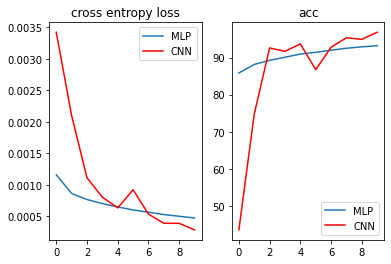

In [15]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure
plt.subplot(1,2,1)
plt.plot(plt_loss_mlp)
plt.plot(plt_loss_cnn,'r')
plt.legend(['MLP','CNN'])
plt.title('cross entropy loss')
plt.subplot(1,2,2)
plt.plot(np.array(plt_acc_mlp)*100)
plt.plot(np.array(plt_acc_cnn)*100,'r')
plt.legend(['MLP','CNN'])
plt.title('acc')
plt.show()

----------------
<font size=4>以上就是用pytorch訓練分類模型的方法</font>


# 我們將所有的程式碼整合成一串
步驟0. 是否使用CUDA <br>
步驟1. data loader處理 <br>
步驟2. 模型宣告 <br>
步驟3. loss function宣告 <br>
步驟4. optimator宣告 <br>
步驟5. 模型開始訓練 <br>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np

# 步驟0. 是否使用CUDA 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

# 步驟1. data loader處理 
transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),
            transforms.ToTensor()
            ])
dataset_train = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
dataset_test = datasets.MNIST('./dataset', train=False, download=False, transform= transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=512)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=512)


# 步驟2. 模型宣告
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512,10)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = self.fc2(x)
        return x
# initialize the MLP
model_mlp = MLP().to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 步驟4. optimator宣告
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)

# 步驟5. 模型開始訓練
total_epoch=20
plt_loss_train,plt_loss_test, plt_acc_test=[],[],[]
for epoch in range(total_epoch):
    # train
    model_mlp.train()
    train_loss_mlp = 0
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        # MLP
        optimizer_mlp.zero_grad()
        output_mlp = model_mlp(data)
        loss_mlp = loss(output_mlp,target)  
        train_loss_mlp += loss_mlp
        loss_mlp.backward()
        optimizer_mlp.step()
    train_loss_mlp /= len(dataloader_train.dataset)
    plt_loss_train.append(train_loss_mlp)
    # Test
    model_mlp.eval()
    test_loss_mlp = 0
    correct_mlp = 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
             # MLP
            output_mlp = model_mlp(data)
            test_loss_mlp += loss(output_mlp, target)
            pred_mlp = output_mlp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_mlp += pred_mlp.eq(target.view_as(pred_mlp)).sum().item()   
    test_loss_mlp /= len(dataloader_test.dataset)
    plt_loss_test.append(test_loss_mlp)    
    plt_acc_test.append(correct_mlp/len(dataloader_test.dataset)) 
    
    print('MLP[epoch: {}/{}], Average loss (Train):{:.4f}, Average loss(Test): {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch+1, total_epoch, 
        train_loss_mlp, test_loss_mlp, 
        correct_mlp, len(dataloader_test.dataset),
        100. * correct_mlp / len(dataloader_test.dataset)))
    
    


MLP[epoch: 1/20], Average loss (Train):0.0028, Average loss(Test): 0.0012, Accuracy: 8569/10000 (86%)
MLP[epoch: 2/20], Average loss (Train):0.0013, Average loss(Test): 0.0009, Accuracy: 8825/10000 (88%)
MLP[epoch: 3/20], Average loss (Train):0.0011, Average loss(Test): 0.0008, Accuracy: 8921/10000 (89%)
MLP[epoch: 4/20], Average loss (Train):0.0010, Average loss(Test): 0.0007, Accuracy: 9000/10000 (90%)
MLP[epoch: 5/20], Average loss (Train):0.0009, Average loss(Test): 0.0006, Accuracy: 9083/10000 (91%)
MLP[epoch: 6/20], Average loss (Train):0.0008, Average loss(Test): 0.0006, Accuracy: 9138/10000 (91%)
MLP[epoch: 7/20], Average loss (Train):0.0008, Average loss(Test): 0.0006, Accuracy: 9213/10000 (92%)
MLP[epoch: 8/20], Average loss (Train):0.0007, Average loss(Test): 0.0005, Accuracy: 9255/10000 (93%)
MLP[epoch: 9/20], Average loss (Train):0.0007, Average loss(Test): 0.0005, Accuracy: 9297/10000 (93%)
MLP[epoch: 10/20], Average loss (Train):0.0007, Average loss(Test): 0.0005, Accura

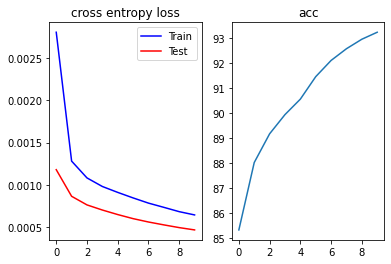

In [9]:

plt.figure
plt.subplot(1,2,1)
plt.plot(plt_loss_train,'b')
plt.plot(plt_loss_test,'r')
plt.legend(['Train','Test'])
plt.title('cross entropy loss')
plt.subplot(1,2,2)
plt.plot(np.array(plt_acc_mlp)*100)
plt.title('acc')
plt.show()